In [24]:
from random import choices
import cirq


### Initiate Constants

In [25]:
num_bits = 10

encode_gates = {0: cirq.I, 1: cirq.X} # Gates that produce the 0 and 1 quantums states, which represents the keys
basis_gates = {"Z": cirq.I, "X": cirq.H} # Gates that will create the correct qubit encryption

message = "Quantum Computing"

### Create Alice Key and Alice Encryption Bases

In [26]:
alice_key = choices([0, 1], k = num_bits)
alice_key

[0, 0, 0, 0, 1, 0, 1, 1, 1, 0]

In [27]:
alice_bases = choices(['Z', 'X'], k = num_bits)
alice_bases

['Z', 'Z', 'X', 'Z', 'Z', 'Z', 'Z', 'X', 'Z', 'Z']

### Encode Alice Key into Qubits

In [28]:
alice_circuit = cirq.Circuit()
qubits = cirq.NamedQubit.range(num_bits, prefix = 'q')

for bit in range(num_bits):

 encode_value = alice_key[bit]
 encode_gate = encode_gates[encode_value]

 basis_value = alice_bases[bit]
 basis_gate = basis_gates[basis_value]

 qubit = qubits[bit]
 alice_circuit.append(encode_gate(qubit))
 alice_circuit.append(basis_gate(qubit))

alice_circuit

q0: ───I───I───

q1: ───I───I───

q2: ───I───H───

q3: ───I───I───

q4: ───X───I───

q5: ───I───I───

q6: ───X───I───

q7: ───X───H───

q8: ───X───I───

q9: ───I───I───

### Alice sends her encrypted key to Bob

> _Vroom Vroom Vroom!_

### Bob picks decryption bases

In [29]:
bob_bases = choices(['Z', 'X'], k = num_bits)
bob_bases

['Z', 'X', 'X', 'X', 'X', 'X', 'Z', 'Z', 'X', 'X']

### Create Bob's decryption circuit

In [30]:
bob_circuit = cirq.Circuit()
for bit in range(num_bits):
    basis_value = bob_bases[bit]
    basis_gate = basis_gates[basis_value]

    qubit = qubits[bit]
    bob_circuit.append(basis_gate(qubit))
    
bob_circuit.append(cirq.measure(qubits, key = 'bob key'))
bob_circuit

q0: ───I───M('bob key')───
           │
q1: ───H───M──────────────
           │
q2: ───H───M──────────────
           │
q3: ───H───M──────────────
           │
q4: ───H───M──────────────
           │
q5: ───H───M──────────────
           │
q6: ───I───M──────────────
           │
q7: ───I───M──────────────
           │
q8: ───H───M──────────────
           │
q9: ───H───M──────────────

### Create Bob key

In [31]:

bb84_circuit = alice_circuit + bob_circuit

print(bb84_circuit)
sim = cirq.Simulator()
results = sim.run(bb84_circuit)
bob_key = results.measurements['bob key'][0]


print(bob_key)

q0: ───I───I───I───M('bob key')───
                   │
q1: ───I───I───H───M──────────────
                   │
q2: ───I───H───H───M──────────────
                   │
q3: ───I───I───H───M──────────────
                   │
q4: ───X───I───H───M──────────────
                   │
q5: ───I───I───H───M──────────────
                   │
q6: ───X───I───I───M──────────────
                   │
q7: ───X───H───I───M──────────────
                   │
q8: ───X───I───H───M──────────────
                   │
q9: ───I───I───H───M──────────────
[0 1 0 0 1 0 1 1 1 0]


### Create final shared key

In [32]:
final_alice_key = []
final_bob_key = []

for bit in range(num_bits):
    if alice_bases[bit] == bob_bases[bit]:
        final_alice_key.append(alice_key[bit])
        final_bob_key.append(bob_key[bit])
print("Final Alice key: ", final_alice_key)
print("Final Bob key: ", final_bob_key)


Final Alice key:  [0, 0, 1]
Final Bob key:  [0, 0, 1]


### Check if the bases match
* Only the first two items in the bases will be used to check whether the bases match
* In the case that the bases are found to match, the first two items will be discarded because they were sent through a public channel and thus may be exposed to eavesdroppers

In [33]:
if final_alice_key[0] == final_bob_key[0] and final_alice_key[1] == final_bob_key[1]:
    final_alice_key = final_alice_key[2:]
    final_bob_key = final_bob_key[2:]

    print('We can use our keys!')

else:
 print('Eve was listening, we need to use a different channel!')

We can use our keys!


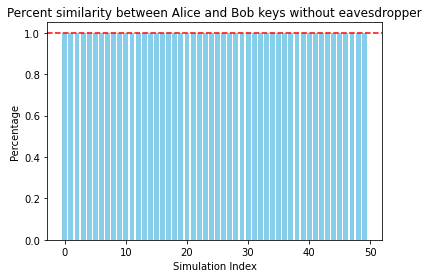

In [37]:
def simulate():
    '''
    Create Bob's key
    '''
    sim = cirq.Simulator()
    results = sim.run(bb84_circuit)
    bob_key = results.measurements['bob key'][0]
    
    '''
    Create final shared keys
    '''
    final_alice_key = []
    final_bob_key = []

    for bit in range(num_bits):
        if alice_bases[bit] == bob_bases[bit]:
            final_alice_key.append(alice_key[bit])
            final_bob_key.append(bob_key[bit])

    '''
    Create the percentage of same elements in Alice and Bob's respective keys
    '''    
    total_agree = 0
    for i in range(len(final_bob_key)):
        if final_bob_key[i]==final_alice_key[i]:
            total_agree += 1
    return (total_agree/len(final_alice_key))

num_runs = 50
percentages = []
for i in range(num_runs):
    percentages.append(simulate())

import matplotlib.pyplot as plt

def bar_chart(percentage_list):
    # Define the x-axis values as indices of the list
    x_values = range(len(percentage_list))
    average_percentage = sum(percentage_list) / len(percentage_list)
    # Create a bar chart
    plt.bar(x_values, percentage_list, color='skyblue')
    
    # Add labels and title
    plt.xlabel('Simulation Index')
    plt.ylabel('Percentage')
    plt.title('Percent similarity between Alice and Bob keys without eavesdropper')
    
    plt.axhline(y=average_percentage, color='red', linestyle='--', label=f'Average: {average_percentage*100:.1f}%')
    # Show plot
    plt.show()

bar_chart(percentages)


### Encrypt Alice Key using character-by-character encoding
* This encryption method involves converting each character in my message string to its binary representation (ASCII or Unicode depending on the character ).
* Then, an XOR gate is applied on each character with its corresponding 1 or 0 in the key. The XOR gate is picked because it is easily reversable - applying two XOR gates will yield the original result, making decryption easy.
* As an example, say that the message to encrypt is "quantum" and the Alice's randomly-generated encryption key is [1, 0, 0, 1, 0, 1, 1, 1]. The _encode_ function will output "puaottl". Next, if I run _decode("puaottl", [1, 0, 0, 1, 0, 1, 1, 1])_, the output will return back to "quantum".

In [1]:
def encode(message, key):
    encoded_message = ""
    for i in range(len(message)):
        char = message[i]
        key_code = key[i % len(key)]  # Cycle through the key list
        char_code = ord(char) # Convert characters in message to integer codes (ASCII/Unicode)
        encoded_code = char_code ^ key_code # Perform  XOR on the codes
        encoded_char = chr(encoded_code) # Convert the encoded code back to a character
        encoded_message += encoded_char # Add encoded letter to encrypted message
    return encoded_message

def decode(encoded_message, key):
    return encode(encoded_message, key)  # Reuse for decoding

In [9]:
print(encode("Quantum computing is cool!", [1, 0, 0, 1, 0, 1, 1, 1]))

Puaottl!bomquuhof ir bnnm!


In [10]:
print(decode("Puaottl!bomquuhof ir bnnm!", [1, 0, 0, 1, 0, 1, 1, 1]))

Quantum computing is cool!


In [55]:
# Example Usage of encode() and decode()

example_key = [1, 0, 0, 1, 0, 1, 1, 1]
encoded_msg = encode("quantum", example_key)
decoded_msg = decode(encoded_msg, example_key)
print(encoded_msg)
print(decoded_msg)


puaottl
quantum


In [56]:
#Encode our message
encoded_msg = encode(message, final_alice_key)
encoded_msg

'Puanutl Colqttinf'

### Send Bob the encoded message
> _Vroom Vroom Vroom!_

### Bob decrypts the encoded message

In [57]:
decoded_msg = decode(encoded_msg, final_bob_key)
decoded_msg

'Quantum Computing'